In [2]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np
from qiskit import transpile
from qiskit import QuantumCircuit
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager




def linear_model(x, a, b):
    return a * x + b


def quadratic_model(x, a, b, c):
    return a * x**2 + b * x + c


def exponential_model(x, a, b, c):
    return a * np.exp(-b * x) + c


def zne_method(method="linear", xdata=[], ydata=[]):

    if method == "linear":
        popt, _ = curve_fit(linear_model, xdata, ydata)
        zero_val = linear_model(0, *popt)
        fit_fn = linear_model
    elif method == "quadratic":
        popt, _ = curve_fit(quadratic_model, xdata, ydata)
        zero_val = quadratic_model(0, *popt)
        fit_fn = quadratic_model
    elif method == "exponential":
        popt, _ = curve_fit(exponential_model, xdata, ydata, p0=(1, 0.1, 0), maxfev=5000)
        zero_val = exponential_model(0, *popt)
        fit_fn = exponential_model
    else:
        raise ValueError(f"Unknown method '{method}'. Use 'linear', 'quadratic', or 'exponential'.")

    return zero_val, ydata, popt, fit_fn


def plot_zne(scales, values, zero_val, fit_fn, fit_params, method):
    x_plot = np.linspace(0, max(scales), 200)
    y_plot = fit_fn(x_plot, *fit_params)

    plt.figure(figsize=(8, 5))
    plt.plot(scales, values, "o", label="Noisy measurements")
    plt.plot(x_plot, y_plot, "-", label=f"{method.capitalize()} fit")
    plt.axvline(0, linestyle="--", color="gray")
    plt.axhline(zero_val, linestyle="--", color="red", label="Zero-noise estimate")
    plt.xlabel("Noise scaling factor")
    plt.ylabel("⟨Z⟩ Expectation Value")
    plt.title(f"Zero-Noise Extrapolation ({method})")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_backend_errors_and_counts(backends, errors_and_counts_list):

    # Unpack errors and counts from the list
    (
        acc_total_errors,
        acc_two_qubit_errors,
        acc_single_qubit_errors,
        acc_readout_errors,
        single_qubit_gate_counts,
        two_qubit_gate_counts,
    ) = np.array(errors_and_counts_list).T.tolist()

    errors = np.array(
        [
            acc_total_errors,
            acc_two_qubit_errors,
            acc_single_qubit_errors,
            acc_readout_errors,
        ]
    )
    error_labels = [
        "Total Error",
        "Two-Qubit Error",
        "Single-Qubit Error",
        "Readout Error",
    ]
    counts = np.array([single_qubit_gate_counts, two_qubit_gate_counts])
    count_labels = ["Single-Qubit Gate Count", "Two-Qubit Gate Count"]

    # Transpose errors and counts to align with plotting requirements
    errors = errors.T
    counts = counts.T
    # Plot for accumulated errors
    x = np.arange(len(error_labels))  # the label locations
    width = 0.2  # the width of the bars
    fig, ax = plt.subplots(figsize=(10, 5))
    for i in range(len(backends)):
        ax.bar(x + i * width, errors[i], width, label=backends[i].name)
    ax.set_xlabel("Error Type")
    ax.set_ylabel("Accumulated Error")
    ax.set_title("Accumulated Errors by Backend")
    ax.set_xticks(x + width)
    ax.set_xticklabels(error_labels)
    ax.legend()
    plt.show()

    # Plot for gate counts
    x = np.arange(len(count_labels))  # the label locations

    fig, ax = plt.subplots(figsize=(10, 5))
    for i in range(len(backends)):
        ax.bar(x + i * width, counts[i], width, label=backends[i].name)

    ax.set_xlabel("Gate Type")
    ax.set_ylabel("Gate Count")
    ax.set_title("Gate Counts by Backend")
    ax.set_xticks(x + width)
    ax.set_xticklabels(count_labels)
    ax.legend()
    plt.show()

In [1]:
# Check that the account has been saved properly
from qiskit_ibm_runtime import QiskitRuntimeService


service = QiskitRuntimeService(name="qgss-2025")
service.saved_accounts()

{'default-ibm-cloud': {'channel': 'ibm_cloud',
  'url': 'https://cloud.ibm.com',
  'token': 'i4JOtPbeQRjnvJYz07Rcqt9Y8FvIwxK_rQIwtTVpP1uB',
  'instance': 'crn:v1:bluemix:public:quantum-computing:us-east:a/5c9a656123ed441db83e4a66c813d54e:0cccfc19-9d18-4b8a-a67e-1bef5578026c::',
  'verify': True,
  'private_endpoint': False},
 'default-ibm-quantum': {'channel': 'ibm_quantum',
  'url': 'https://auth.quantum.ibm.com/api',
  'token': '86c88659ef1188904bddff366ed1ec2a00f47fc4d38a14c637208ab952db7027e87cb005eec8b46522a6bab66f624fc58b4963790dc09198999870500e501bae',
  'verify': True,
  'private_endpoint': False},
 'qgss-2025': {'channel': 'ibm_quantum_platform',
  'url': 'https://cloud.ibm.com',
  'token': 'AiZi_gvsMskBqzf6cu5oKbcd7ESPvVAvUfHOvN33u_hv',
  'instance': 'crn:v1:bluemix:public:quantum-computing:us-east:a/5c9a656123ed441db83e4a66c813d54e:0cccfc19-9d18-4b8a-a67e-1bef5578026c::',
  'verify': True,
  'private_endpoint': False}}

Necessary Imports

In [3]:
import rustworkx as rx
import numpy as np
import matplotlib.pyplot as plt
from rustworkx.visualization import mpl_draw as draw_graph
from qiskit_ibm_runtime import QiskitRuntimeService
from scipy.optimize import minimize

from qiskit import QuantumCircuit
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.quantum_info import SparsePauliOp, Statevector, DensityMatrix, Operator
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.transpiler import Layout

from qiskit_ibm_runtime import (
    Session,
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions,
)
from qiskit_ibm_runtime.debug_tools import Neat
from qiskit_aer import AerSimulator

from qc_grader.challenges.qgss_2025 import (
    grade_lab2_ex1,
    grade_lab2_ex2,
    grade_lab2_ex3,
    grade_lab2_ex4,
    grade_lab2_ex5,
    grade_lab2_ex6a,
    grade_lab2_ex6b,
)

<a id="exercise_1"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 1: Find the best qubits </b> 

**Your Goal:** Find the qubits with longer T1, T2, higher gate fidelities, and smaller readout errors.

In this first exercise, you will provide the best value of each of the following metrics, as well as the qubit, or pair of qubits, that have this value:

- Relaxation time: T1
- Dephasing time: T2
- Readout error
- Single-qubit gate error: 'PauliX' error
- Two-qubits gate error: 'Ecr' error 

To make your solution robust, you should write a routine that works for any backend.

<i>Note 1: The ECR gate is the two-qubit gate specific to this backend and may differ on other quantum devices, which might have CZ or CNOT gates. You can check the basis gate of backend by using [backend.basis_gates](/docs/api/qiskit-ibm-runtime/ibm-backend).</i>

<I>Note 2: Since the best-performing qubits and their values can change over time, we recommend finding these values across all qubits directly using Python's `min()` and `max()` functions for each run.</i>


</div>

The code below demonstrates how to retrieve and store properties for all qubits from the `ibm_brisbane` backend into an array. Use this as a reference when implementing your function.

In [5]:
# Execute to make arrays of properties
service = QiskitRuntimeService(name="qgss-2025")
# We define a specific backend
brisbane_backend = service.backend("ibm_brisbane")
# We obtain the system properties, number of qubits and coupling map
properties = brisbane_backend.properties()
num_qubits = brisbane_backend.num_qubits
coupling_map = brisbane_backend.coupling_map

# We define various lists of metrics for all the qubits of the backend
t1, t2, gate_error_x, readout_error, gate_error_ecr = [], [], [], [], []
for i in range(num_qubits):
    t1.append(properties.t1(i))
    t2.append(properties.t2(i))
    gate_error_x.append(properties.gate_error(gate="x", qubits=i))
    readout_error.append(properties.readout_error(i))
for pair in coupling_map:
    gate_error_ecr.append(properties.gate_error(gate="ecr", qubits=pair))

In [6]:
def find_best_metrics(backend: QiskitRuntimeService.backend) -> list[tuple[int or list, float]]:
    """Finds the best-performing qubits and qubit pair based on various hardware metrics."""
    # ---- TODO : Task 1 ---
    # Goal: Obtain the best value and the index or indices of the qubits of the following metrics:
    properties=backend.properties()
    num_qubits=backend.num_qubits
    coupling_map=brisbane_backend.coupling_map.get_edges()
    t1,t2,gate_error_x,readout_error,gate_error_ecr=[],[],[],[],[]

    for i in range(num_qubits):
      t1.append(properties.t1(i))
      t2.append(properties.t2(i))
      gate_error_x.append(properties.gate_error(gate="x", qubits=i))
      readout_error.append(properties.readout_error(i))
    for pair in coupling_map:
      gate_error_ecr.append(properties.gate_error(gate="ecr", qubits=pair))
    #find the best qubit (index_t1_max) with the longest T1 and its value (max_t1)
    max_t1 = max(t1)
    index_t1_max = t1.index(max_t1)

    # T2: Longest is better
    max_t2 = max(t2)
    index_t2_max = t2.index(max_t2)

    # X gate error: Smallest is better
    min_x_error = min(gate_error_x)
    index_min_x_error = gate_error_x.index(min_x_error)

    # Readout error: Smallest is better
    min_readout = min(readout_error)
    index_min_readout = readout_error.index(min_readout)

    # ECR gate error: Smallest is better
    min_ecr_error = min(gate_error_ecr)
    min_ecr_index = gate_error_ecr.index(min_ecr_error)
    min_ecr_pair = coupling_map[min_ecr_index]

    # Return results
    solutions = [
        [int(index_t1_max), max_t1],
        [int(index_t2_max), max_t2],
        [int(index_min_x_error), min_x_error],
        [int(index_min_readout), min_readout],
        [list(min_ecr_pair), min_ecr_error],
    ]
    return solutions

In [7]:
solutions=find_best_metrics(brisbane_backend)
print(solutions)

[[30, 0.00040735123465904434], [29, 0.00039789159923336317], [17, 0.00010482110197955824], [118, 0.00634765625], [[4, 3], 0.002245966097824459]]


In [8]:
# Submit your answer using the following code
grade_lab2_ex1(find_best_metrics)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


# 2. The problem: Max-cut <a id="max-cut"></a>

The maximum cut ([Max-cut](https://en.wikipedia.org/wiki/Maximum_cut)) problem is a graph problem that lies in the category of [NP-hard](https://en.wikipedia.org/wiki/NP-hardnes), which means no algorithm exists that can solve it in polynomial time. Max-cut is an optimization problem with a wide range of applications including clustering, network science, statistical physics, and machine learning. The goal of this problem is to divide the nodes of a graph into two sets using a single cut, in such a way that the number of edges traversed by this cut is maximized. 
Let's visualize it with one example. 

In the picture below you see the max-cut solution of a five-node problem that exemplifies how the graph is divided, maximizing the number of edges cut. Another way to view this problem is to consider that finding the maximum cut in a graph means identifying a way to divide the nodes into two groups such that the number of edges connecting nodes from different groups is as large as possible.

![Illustration of a max-cut problem](attachment:image.png)

In this lab, we will solve a Max-cut problem using a quantum algorithm. We'll also study how quantum noise affects our solution and discuss strategies to reduce its impact, ensuring we can still obtain accurate results despite the noise.

## 2.1 The problem: Define the graph <a id="the-graph"></a>

Now that we have a little bit of context of the Max-cut problem, let's choose a specific graph for which we want to find the maximum cut. In particular, we will choose the graph of the coupling map of a hypothetical quantum computer with all-to-all connectivity $^*$.

$^*$ *Note that the last qubit is not actually connected to the first one, to explicitly break the symmetry of the problem and reduce the number of solutions.*

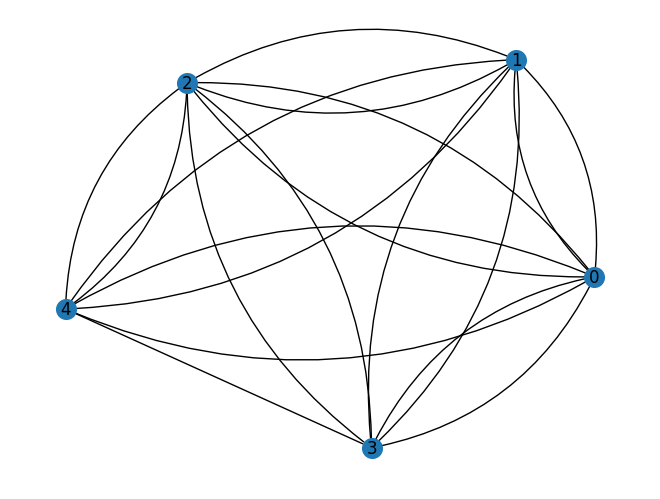

In [9]:
# We define the seed
seed = 43
# We define the number of nodes:
n = 5
# We define the graph
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
generic_backend = GenericBackendV2(n, seed=seed)
weights = 1
# We make it explicitly asymmetrical to have a smaller set of solutions
graph.add_edges_from([(edge[0], edge[1], weights) for edge in generic_backend.coupling_map][:-1])
draw_graph(graph, node_size=200, with_labels=True, width=1)

<a id="exercise_2"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 2: From Graph to Hamiltonian </b> 

**Your Goal:** Convert the 'graph' object we just created into an Ising Hamiltonian, which is the cost function for our Max-cut problem.

In this second exercise you must find the way of mapping the graph problem you are given to a Hamiltonian using the identity and Pauli gates.




</div>

<div class="alert alert-info">
<details>
    <summary> <b>Hint</b> 💡: (Click to expand)</summary>
    The intuition of how to build this Hamiltonian consists of considering a Hilbert space of size n x n in which we add as many terms as edges in the graph, and in which the nodes connected by each edge are represented by Pauli-Z matrices, whereas the rest of the nodes are represented by the identity. <br> <br>
    You can find useful functions in the <a href=https://quantum.cloud.ibm.com/docs/tutorials/advanced-techniques-for-qaoa#graph--hamiltonian>Graph to Hamiltonian</a> section of the <a href="https://quantum.cloud.ibm.com/docs/tutorials/advanced-techniques-for-qaoa">Advanced techniques for QAOA </a>tutorial mentioned above.
    
</details>
</div>

In [10]:
def graph_to_Pauli(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list."""
    pauli_list = []

    # ---- TODO : Task 2 ---
    # Goal: Convert the graph into a list like: [['PauliWord_1', weight_1], ['PauliWord_2', weight_2],...]
    for edge in graph.edge_list():
        pauli_string=["I"]*len(graph)
        pauli_string[edge[0]]="Z"
        pauli_string[edge[1]]="Z"
        weight=graph.get_edge_data(edge[0],edge[1])
        pauli_term="".join(pauli_string)[::-1]
        pauli_list.append((pauli_term,weight))
    # --- End of TODO ---

    return pauli_list


max_cut_paulis = graph_to_Pauli(graph)
cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIIZZ', 'IIZIZ', 'IIZIZ', 'IZIIZ', 'IZIIZ', 'ZIIIZ', 'ZIIIZ', 'IIZZI', 'IIZZI', 'IZIZI', 'IZIZI', 'ZIIZI', 'ZIIZI', 'IZZII', 'IZZII', 'ZIZII', 'ZIZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j])


In [11]:
# Submit your answer using the following code
grade_lab2_ex2(graph_to_Pauli)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


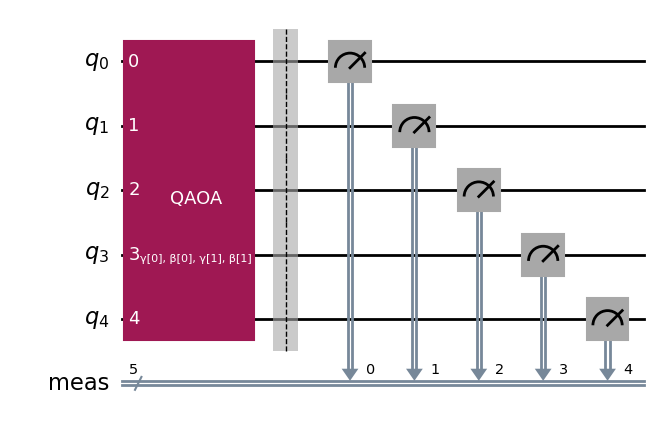

In [13]:
layers = 2
qaoa_circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=layers)
qaoa_circuit.measure_all()
qaoa_circuit.draw("mpl")

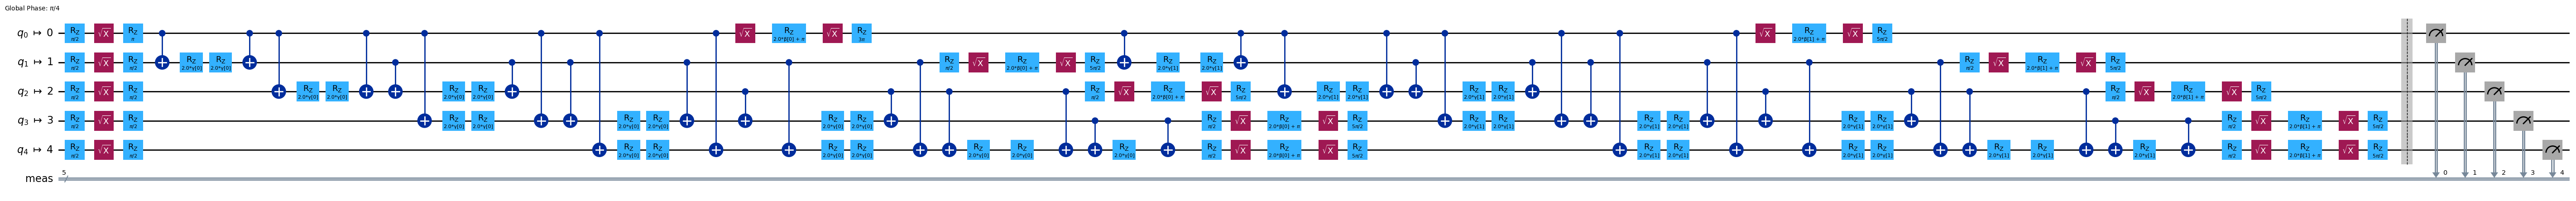

In [14]:
# Create pass manager for transpilation

pm = generate_preset_pass_manager(
    optimization_level=3, backend=generic_backend, seed_transpiler=seed
)

qaoa_circuit_transpiled = pm.run(qaoa_circuit)
qaoa_circuit_transpiled.draw("mpl", fold=False, idle_wires=False)

In [15]:
init_params = np.zeros(2 * layers)

<a id="exercise_3"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 3: Error Counting </b> 

**Your Goal:** Estimate the total error of the quantum circuit. 

In this third exercise you will estimate the total error introduced by all the instructions when executing quantum circuits on different backends by completing the `accululated_errors` function.<br> 
In particular, you'll account for the errors introduced by:

- Single-qubit gates: Depending on the backend, these may include 'rz','x', or 'sx', and you'll have to access each instruction name.
- Two-qubit gates: Depending on the backend, these may include 'cz', 'cx', or 'ecr' gates. You’ll need to identify which gate is used on each backend.
- Readout errors: These contribute a constant error added at the end of the total accumulated error, only on the physical qubits where your circuit is transpiled.

Keep in mind that each qubit has different error rates, so you cannot simply count all operations and multiply by average error values you see on the Compute resources page on IBM Quantum Platform. <br>
While this approximation might yield similar results, the goal of this exercise is to teach you how to access detailed backend information and perform a more accurate estimation of the specific error rates per qubit.

Also, don't count the measure gates as single-qubit gates, as their error is already included in the readout error.

</div>


In [12]:
# Define a function that calculates the accumulated total errors of single and two qubit gates and readout


def accumulated_errors(backend: QiskitRuntimeService.backend, circuit: QuantumCircuit) -> list:
    """Compute accumulated gate and readout errors for a given circuit on a specific backend."""

    # Initializing quantities
    acc_single_qubit_error = 0
    acc_two_qubit_error = 0
    single_qubit_gate_count = 0
    two_qubit_gate_count = 0
    acc_readout_error = 0

        # Defining useful variables
    properties = backend.properties()
    qubit_layout = list(circuit.layout.initial_layout.get_physical_bits().keys())[:n]
    store=[]
    # ---- TODO : Task 3 ---
    # Goal: Define the following quantities:
    # acc_total_error, acc_two_qubit_error, acc_single_qubit_error, acc_readout_error, single_qubit_gate_count, two_qubit_gate_count
    
    # TODO Define readout error (only for qubits in qubit_layout) using `properties.readout_error`
    acc_readout_error=0
    for q in qubit_layout:
        acc_readout_error+= properties.readout_error(q)
    # TODO Define two qubit gates for the different backends using `backend.configuration()`
    backend_config=backend.configuration()
    if "ecr" in backend_config.basis_gates: # TODO
        two_qubit_gate = "ecr"
    elif "cz" in backend_config.basis_gates: # TODO
        two_qubit_gate = "cz"
    # TODO Loop over the instructions in `circuit.data` to account for the single and two-qubit errors and single and two qubit gate counts
    for instruction in circuit.data:
        gate=instruction.operation
        qubits=[circuit.find_bit(q).index for q in instruction.qubits]
        if gate.name=="measure":
            continue
        if len(qubits) == 1:
           q = qubits[0]
           single_qubit_gate_count+=1
           acc_single_qubit_error+=properties.gate_error(gate.name,q)
        elif len(qubits)==2:
            q1, q2 = qubits
            two_qubit_gate_count += 1
            acc_two_qubit_error += properties.gate_error(two_qubit_gate, [q1, q2])

    # --- End of TODO ---

    acc_total_error = acc_two_qubit_error + acc_single_qubit_error + acc_readout_error
    results = [
        acc_total_error,
        acc_two_qubit_error,
        acc_single_qubit_error,
        acc_readout_error,
        single_qubit_gate_count,
        two_qubit_gate_count,
    ]
    return results

In [16]:
# backends=[service.backend("alt_brisbane"),service.backend("alt_kawasaki"),service.backend("alt_torino")]
real_backends = [
    service.backend("ibm_brisbane"),
    service.backend("ibm_sherbrooke"),
    service.backend("ibm_torino"),
]

In [17]:
noisy_fake_backends = []
for backend in real_backends:
    noisy_fake_backends.append(AerSimulator.from_backend(backend, seed_simulator=seed))
print(f"The noisy simulators are {noisy_fake_backends}")

The noisy simulators are [AerSimulator('aer_simulator_from(ibm_brisbane)'
             noise_model=<NoiseModel on ['sx', 'ecr', 'measure', 'x', 'reset', 'id']>), AerSimulator('aer_simulator_from(ibm_sherbrooke)'
             noise_model=<NoiseModel on ['sx', 'ecr', 'measure', 'x', 'reset', 'id']>), AerSimulator('aer_simulator_from(ibm_torino)'
             noise_model=<NoiseModel on ['sx', 'cz', 'measure', 'x', 'reset', 'id']>)]


In [18]:
qaoa_transpiled_list = []
errors_and_counts_list = []
for noisy_fake_backend in noisy_fake_backends:
    pm = generate_preset_pass_manager(
        backend=noisy_fake_backend,
        optimization_level=3,
        seed_transpiler=seed,
    )
    circuit = pm.run(qaoa_circuit)
    qaoa_transpiled_list.append(circuit)

    errors_and_counts = accumulated_errors(noisy_fake_backend, circuit)
    errors_and_counts_list.append(errors_and_counts)
# You can print your results to visualize if they are correct
for backend, (
    acc_total_error,
    acc_two_qubit_error,
    acc_single_qubit_error,
    acc_readout_error,
    single_qubit_gate_count,
    two_qubit_gate_count,
) in zip(noisy_fake_backends, errors_and_counts_list):
    print(f"Backend {backend.name}")
    print(f"Accumulated two-qubit error of {two_qubit_gate_count} gates: {acc_two_qubit_error:.3f}")
    print(
        f"Accumulated one-qubit error of {single_qubit_gate_count} gates: {acc_single_qubit_error:.3f}"
    )
    print(f"Accumulated readout error: {acc_readout_error:.3f}")
    print(f"Accumulated total error: {acc_total_error:.3f}\n")

Backend aer_simulator_from(ibm_brisbane)
Accumulated two-qubit error of 70 gates: 0.222
Accumulated one-qubit error of 457 gates: 0.023
Accumulated readout error: 0.108
Accumulated total error: 0.353

Backend aer_simulator_from(ibm_sherbrooke)
Accumulated two-qubit error of 70 gates: 0.224
Accumulated one-qubit error of 431 gates: 0.026
Accumulated readout error: 0.118
Accumulated total error: 0.367

Backend aer_simulator_from(ibm_torino)
Accumulated two-qubit error of 70 gates: 0.156
Accumulated one-qubit error of 250 gates: 0.028
Accumulated readout error: 0.080
Accumulated total error: 0.263



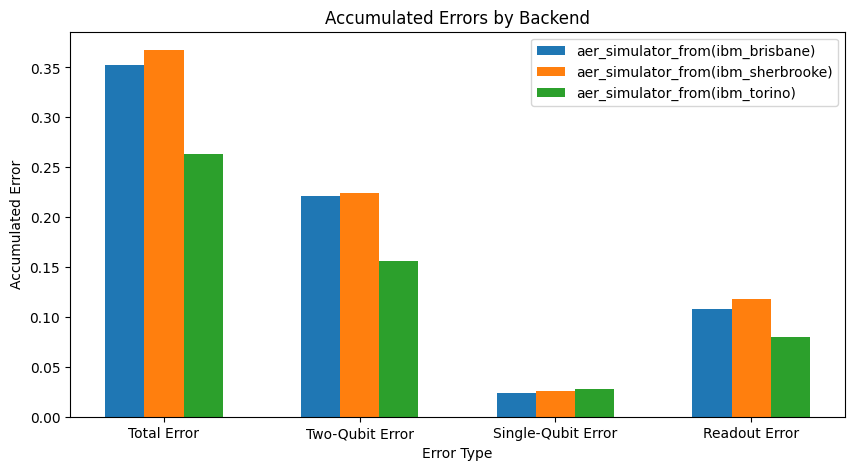

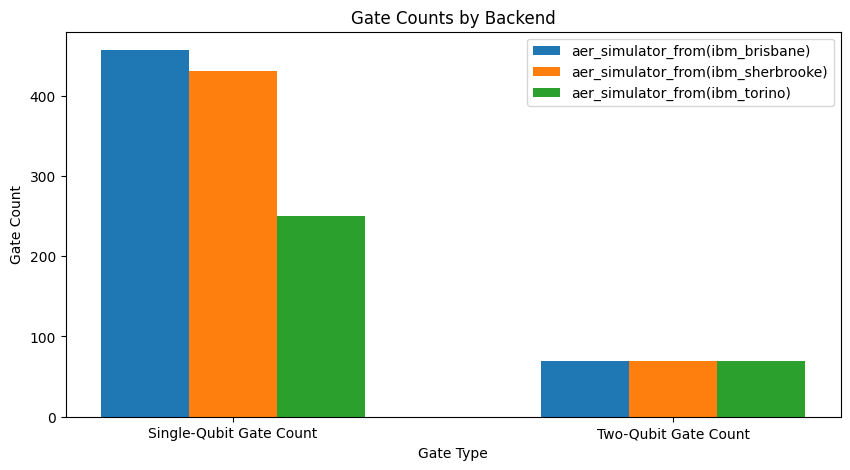

In [19]:
plot_backend_errors_and_counts(noisy_fake_backends, errors_and_counts_list)

In [20]:
# Submit your answer using the following code
grade_lab2_ex3(accumulated_errors)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


In [22]:
objective_func_vals = []


def cost_func_estimator(
    params: list, ansatz: QuantumCircuit, isa_hamiltonian: SparsePauliOp, estimator: Estimator
) -> float:
    """Compute the cost function value using a parameterized ansatz and an estimator for a given Hamiltonian."""
    if isa_hamiltonian.num_qubits != ansatz.num_qubits:
        isa_hamiltonian = isa_hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    objective_func_vals.append(cost)
    return cost


def train_qaoa(
    params: list,
    circuit: QuantumCircuit,
    hamiltonian: SparsePauliOp,
    backend: QiskitRuntimeService.backend,
) -> tuple:
    """Optimize QAOA parameters using COBYLA and an estimator on a given backend."""
    with Session(backend=backend) as session:
        options = {"simulator": {"seed_simulator": seed}}
        estimator = Estimator(mode=session, options=options)
        estimator.options.default_shots = 100000

        result = minimize(
            cost_func_estimator,
            params,
            args=(circuit, hamiltonian, estimator),
            method="COBYLA",
            options={"maxiter": 200, "rhobeg": 1, "catol": 1e-3, "tol": 0.0001},
        )
    print(result)
    return result, objective_func_vals


result_qaoa, objective_func_vals = train_qaoa(
    init_params, qaoa_circuit_transpiled, cost_hamiltonian, generic_backend
)


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.724092759072409
       x: [ 9.735e-01  9.780e-01 -5.691e-01  1.029e+00]
    nfev: 63
   maxcv: 0.0


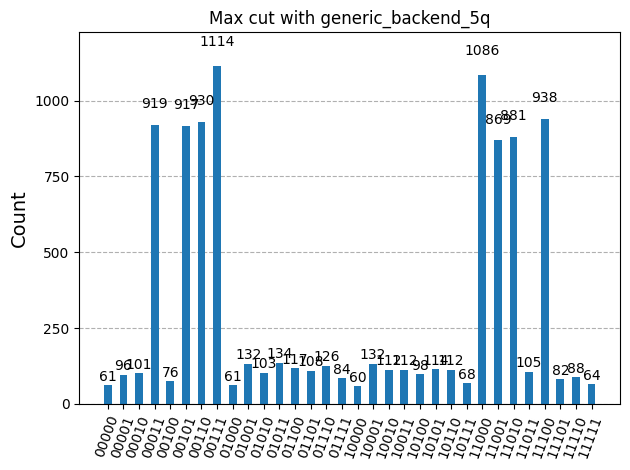

In [23]:
# Get the optimized parameters from the result
opt_params = result_qaoa.x
SHOTS = 10000


def sample_qaoa(opt_params, circuit, backend):

    # Submit the circuit to Sampler
    options = {"simulator": {"seed_simulator": seed}}
    sampler = Sampler(mode=backend, options=options)
    job = sampler.run([(circuit, opt_params)], shots=SHOTS)
    results_sampler = job.result()
    counts_list = results_sampler[0].data.meas.get_counts()
    display(plot_histogram(counts_list, title=f"Max cut with {backend.name}"))

    return counts_list


counts_list = sample_qaoa(opt_params, qaoa_circuit_transpiled, generic_backend)

In [ ]:
opt_params_list = []
counts_list_backends = []
for noisy_fake_backend, circuit in zip(noisy_fake_backends[:1], qaoa_transpiled_list[:1]):
    result_backend, _ = train_qaoa(init_params, circuit, cost_hamiltonian, noisy_fake_backend)
    opt_params = result_backend.x
    opt_params_list.append(opt_params)
    counts_list_backend = sample_qaoa(opt_params, circuit, noisy_fake_backend)
    counts_list_backends.append(counts_list_backend)

# 3.2 Estimating errors using NEAT <a id="neat"></a>

The error estimation we have done above is a nice approximation of how noisy a device is going to be. Qiskit offers us another alternative, the Noisy Estimator Analyzer Tool (NEAT). NEAT is a function designed to help users understand and predict the performance of quantum estimation tasks, particularly when using the Estimator primitive. It leverages the `qiskit-aer` simulator to perform both ideal (noiseless) and noisy simulations of quantum circuits. 

A key feature of NEAT is its ability to simulate Clifford circuits efficiently. For non-Clifford circuits, NEAT can automatically convert them to their nearest Clifford equivalents that approximate their quantum state. This makes NEAT especially useful for performing a noise analysis of our quantum circuits before running them on real quantum hardware. However, this approximation introduces limitations, since Clifford equivalents do not perfectly replicate the behavior of non-Clifford circuits, and therefore the simulation may lose accuracy in certain cases.

From a practical point of view, one way to use NEAT is to simulate a quantum circuit in a noisy and noiseless scenario measuring an observable whose expectation value is exactly 1 in the ideal (noiseless) case. In this setup, any deviation from 1 in the noisy simulation directly reflects the impact of noise on the circuit. An easy way to ensure that the observable meets the requirements is choosing:
$$
\hat{O}=|\psi\rangle\langle \psi|, \quad \textrm{since} \quad \langle \psi |\hat{O}|\psi \rangle=1, 
$$
where $|\psi\rangle$ is the quantum state generated by the circuit we want to simulate. 

Let's apply NEAT to our different noisy backends to see how they perform.

In [ ]:
results = []
for backend, opt_params in zip(noisy_fake_backends, opt_params_list):
    print(f"\nRunning on backend: {backend.name}")

    # Prepare the QAOA circuit with optimized parameters
    qaoa_neat = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=layers)
    qc = qaoa_neat.assign_parameters(opt_params)

    # Transpile the circuit
    qc_transpiled = generate_preset_pass_manager(
        optimization_level=3,
        basis_gates=backend.configuration().basis_gates[:n],
        seed_transpiler=seed,
    ).run(qc)
    # Use cost Hamiltonian as observable for Cliffordization
    obs = cost_hamiltonian
    analyzer = Neat(backend)
    clifford_pub = analyzer.to_clifford([(qc_transpiled, obs)])[0]

    # Construct observable from Clifford circuit
    state_clifford = Statevector.from_instruction(clifford_pub.circuit)
    obs_clifford = SparsePauliOp.from_operator(Operator(DensityMatrix(state_clifford).data))

    # Apply layout
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1, seed_transpiler=seed)
    isa_qc = pm.run(clifford_pub.circuit)
    isa_obs = obs_clifford.apply_layout(isa_qc.layout)

    # Prepare pubs and simulate
    pubs = [(isa_qc, isa_obs)]
    result_noiseless = (
        analyzer.ideal_sim(pubs, cliffordize=True, seed_simulator=seed)._pub_results[0].vals
    )
    noisy_results = (
        analyzer.noisy_sim(pubs, cliffordize=True, seed_simulator=seed)._pub_results[0].vals
    )

    # Store and print results
    results.append({"backend": backend.name, "noiseless": result_noiseless, "noisy": noisy_results})
    print(f"Ideal results on {backend.name}:\n{result_noiseless:.3f}")
    print(f"Noisy results on {backend.name}:\n{noisy_results:.3f}")

# 4. Transpiler <a id="transpiler"></a>

The transpiler is one of the most important and useful tools for running quantum circuits on real quantum hardware. It serves as a bridge between the abstract, idealized version of a quantum circuit and the physical implementation on the actual quantum device. When you design a circuit, you typically use virtual qubits and ideal gates without considering the hardware's specific limitations. The transpiler translates this high-level circuit into a version that can be implemented on a real quantum computer, using only the physical qubit's gate operations available on the device.

For example, suppose your circuit includes a CNOT gate between virtual qubits 0 and 1. On a real device, these two qubits might not be directly connected. In such cases, the transpiler inserts a series of SWAP gates to move the quantum states to physically adjacent qubits, enabling the CNOT operation. Alternatively, the transpiler might find a more efficient qubit mapping, such that virtual qubits 0 and 1 are reassigned to physical qubits that are directly connected - for example, qubits 3 and 4, hence avoiding the need for additional SWAP gates.

Up to now we have been using the transpiler implicitly when executing the pass manager in `generate_preset_pass_manager`. However, now we will focus on understanding it better and leveraging it to its fullest for better circuit design.

# 4.1 Minimizing the two-qubit gates <a id="min-two-qubit"></a>

One of the most important tasks of a quantum transpiler is to determine an optimal qubit layout for executing a quantum circuit. This involves finding the best mapping between the circuit's virtual qubits and the device's physical qubits. To do so, there are a few things to take into consideration. 

First, the transpiler must check for all the two-qubit gates in the circuit and ensure that the selected physical qubits are connected in a way that enables these operations and reduces the necessity of using additional SWAP gates. This requires inspecting the coupling map, which shows how physical qubits are connected.

First we will perform a transpilation of the quantum circuit to a layout in the quantum computer that minimizes the number of two-qubit gates, since that will be the main source of error.

In particular, we will consider the `ibm_brisbane` backend, where, as shown in [Section 3.1](#choosing-backend), two-qubit gate errors account for the majority of the total accumulated error.

In [25]:
# We select the `ibm_brisbane` backend
num_backend = 0
noisy_fake_backend = noisy_fake_backends[num_backend]

pm = generate_preset_pass_manager(
    backend=noisy_fake_backend,
    optimization_level=3,
    seed_transpiler=seed,
    layout_method="sabre",
)
circuit_transpiled = pm.run(qaoa_circuit)


def two_qubit_gate_errors_per_circuit_layout(
    circuit: QuantumCircuit, backend: QiskitRuntimeService.backend
) -> tuple:
    """Calculate accumulated two-qubit gate errors and related metrics for a given circuit layout."""
    pair_list = []
    error_pair_list = []
    error_acc_pair_list = []
    two_qubit_gate_count = 0
    properties = backend.properties()
    if "ecr" in (backend.configuration().basis_gates):
        two_qubit_gate = "ecr"
    elif "cz" in (backend.configuration().basis_gates):
        two_qubit_gate = "cz"
    for instruction in circuit.data:
        if instruction.operation.num_qubits == 2:
            two_qubit_gate_count += 1
            pair = [instruction.qubits[0]._index, instruction.qubits[1]._index]
            error_pair = properties.gate_error(gate=two_qubit_gate, qubits=pair)
            if pair not in (pair_list):
                pair_list.append(pair)
                error_pair_list.append(error_pair)
                error_acc_pair_list.append(error_pair)
            else:
                pos = pair_list.index(pair)
                error_acc_pair_list[pos] += error_pair

    acc_two_qubit_error = sum(error_acc_pair_list)
    return (
        acc_two_qubit_error,
        two_qubit_gate_count,
        pair_list,
        error_pair_list,
        error_acc_pair_list,
    )


(
    acc_two_qubit_error,
    two_qubit_gate_count,
    pair_list,
    error_pair_list,
    error_acc_pair_list,
) = two_qubit_gate_errors_per_circuit_layout(circuit_transpiled, noisy_fake_backend)
two_qubit_ops_list = [int(a / b) for a, b in zip(error_acc_pair_list, error_pair_list)]
# We print the results
print(f"The pairs of qubits that need to perform two-qubit operations are:\n {pair_list}")
print(
    f"The errors introduced by each of the two-qubit operations are:\n {[round(err,3) for err in error_pair_list]}"
)
print(
    f"The accumulated errors introduced by each of the two-qubit operations are:\n {[round(err,3) for err in error_acc_pair_list]}"
)
print(f"The repetitions of each one of the two-qubit operations is:\n {two_qubit_ops_list}")
print(f"The number of two-qubit operations in total:\n {two_qubit_gate_count}")
print(f"The total accumulated error by two-qubit operations is:\n {acc_two_qubit_error:.3f}")

The pairs of qubits that need to perform two-qubit operations are:
 [[62, 72], [81, 72], [62, 61], [62, 63]]
The errors introduced by each of the two-qubit operations are:
 [0.009, 0.005, 0.014, 0.007]
The accumulated errors introduced by each of the two-qubit operations are:
 [0.275, 0.06, 0.18, 0.107]
The repetitions of each one of the two-qubit operations is:
 [29, 13, 13, 15]
The number of two-qubit operations in total:
 70
The total accumulated error by two-qubit operations is:
 0.622


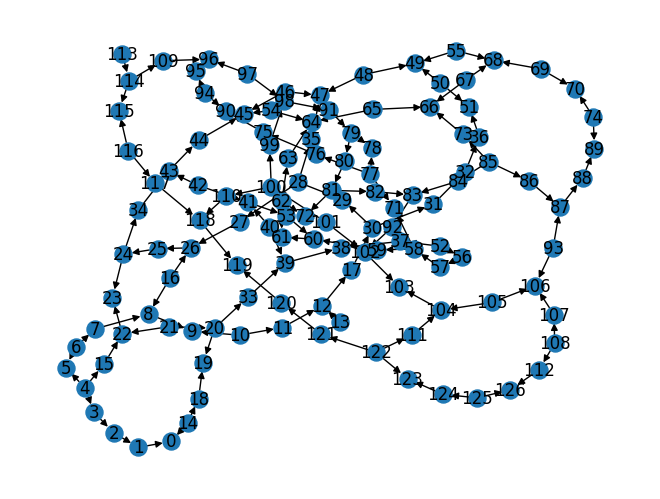

In [26]:
# We build a graph with the connectivity constraints of our backend that includes the two-qubit gate errors as weights in the edges
graph = rx.PyDiGraph()
graph.add_nodes_from(np.arange(0, noisy_fake_backend.num_qubits, 1))
two_qubit_gate = "ecr"
graph.add_edges_from(
    [
        (
            edge[0],
            edge[1],
            noisy_fake_backend.properties().gate_error(
                gate=two_qubit_gate, qubits=(edge[0], edge[1])
            ),
        )
        for edge in noisy_fake_backend.coupling_map
    ]
)
draw_graph(graph, node_size=150, with_labels=True, width=1)

In [27]:
def remap_nodes(original_labels: list, edge_list: list[list]) -> list[list[int]]:
    """Remap node labels to a new sequence starting from 0 based on their order in original_labels."""
    label_mapping = {label: idx for idx, label in enumerate(original_labels)}
    remapped = [[label_mapping[src], label_mapping[dst]] for src, dst in edge_list]
    return remapped


layout_list = list(circuit_transpiled.layout.initial_layout.get_physical_bits().keys())[:5]
logical_pair_list = remap_nodes(layout_list, pair_list)
print(f"Physical qubit layout list:\n {layout_list}")
print(f"\nOriginal two-qubit gates list:\n {pair_list}")
print(f"\nRemapped two-qubit gates list (in logical qubits):\n {logical_pair_list}")

Physical qubit layout list:
 [72, 62, 81, 61, 63]

Original two-qubit gates list:
 [[62, 72], [81, 72], [62, 61], [62, 63]]

Remapped two-qubit gates list (in logical qubits):
 [[1, 0], [2, 0], [1, 3], [1, 4]]



<a id="exercise_4"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 4: Good Mapping </b> 

**Your Goal:** Find all the good qubit layouts. 

In this fourth exercise you will find ALL the possible qubit layouts that have a smaller two-qubit gate accumulated error than the layout transpilation of the above, whose value is stored in the variable `acc_two_qubit_error`. This problem can be reformulated as a graph problem in which you need to find ALL the paths in the graph above which the total edge weights sum to less than the specified threshold and that have the same connectivity of that in `logical_pair_list`.


</div>

<div class="alert alert-block alert-warning">
<b>Warning: Don't try to solve it by brute force!</b>

If you try a brute force approach, it might take hours of computation, as there are too many paths. Instead, restrict the search to only the paths that have the same connectivity of `logical_pair_list`, which are <100, and your computation will take less than 1 second.
</div>

</div>

<div class="alert alert-info">
<details>
    <summary> <b>Hint</b> 💡: (Click to expand)</summary>
    
The proposed workflow for this exercise is:

1. Start from each node in the graph and iteratively build paths by extending them one step at a time. 

2. At each step, use the `logical_pair_list` to decide which node in the current path to expand from.

3. Depending on whether the node we are expanding from in the path corresponds to the control or the target qubit (based on `logical_pair_list`), we choose how to access its neighbors:

    3.1 If it's the control qubit, we use directed edges (`graph.neighbors`).

    3.2 If it's the target qubit, we use undirected edges (`graph.neighbors_undirected`).

4. As you extend each path, calculate the cumulative weight by multiplying the edge weight (`graph.get_edge_data(edge_1,edge_2)`) by the corresponding value in `two_qubit_ops_list`. Note that if you are using the undirected neighbors, you should use `graph.get_edge_data(edge_2,edge_1)`.

5. When the path is complete, i.e., when it gets to the length of the `two_qubit_ops_list`, check to only keep paths whose total weight stays below the threshold.

</details>

</div>

Execute the below cell on QBraid.

In [ ]:
def find_paths_with_weight_sum_below_threshold(
    graph: rx.PyDiGraph,
    threshold: float,
    two_qubit_ops_list: list[int],
    logical_pair_list: list[list[int]],
) -> tuple[list[list[int]], list[float]]:
    """Find all valid paths through a graph whose weighted sum is below a given threshold."""
    valid_paths = []
    valid_weights = []

    # Iterate over all possible starting nodes in the graph
    for start_node in range(graph.num_nodes()):
        # Initialize the list of paths with a single-node path starting from the current node
        paths = [[start_node]]
        # Initialize the corresponding weights for each path (starting with 0)
        weights = [0]
        # Iterate through each step in the sequence of two-qubit operations
        for i in range(len(two_qubit_ops_list)):
            new_paths = []    
            new_weights = []  
            # Go through each current path and its weight
            for path, weight in zip(paths, weights):
                # Determine which node in the path we are going to expand from using logical_pair_list
                if logical_pair_list[i][0] < logical_pair_list[i][1]:
                    index_of_expanding_node = logical_pair_list[i][0] # control qubit
                    node_to_expand_from = path[index_of_expanding_node]
                    # Explore all neighbors of the node_to_expand_from
                    for neighbor in graph.neighbors(node_to_expand_from):
                        # Ensure we don't revisit nodes and the edge exists
                        if neighbor not in path and graph.has_edge(node_to_expand_from, neighbor):
                            # Calculate the edge weight, scaled by the number of times the gate is applied
                            edge_weight = graph.get_edge_data(node_to_expand_from, neighbor) * two_qubit_ops_list[i]
                            # Extend the path and update the weight
                            new_paths.append(path + [neighbor])
                            new_weights.append(weight + edge_weight)
                else:
                    index_of_expanding_node = logical_pair_list[i][1] # target qubit
                    node_to_expand_from = path[index_of_expanding_node]
                    # Explore all undirected_neighbors of the node_to_expand_from
                    for neighbor in graph.neighbors_undirected(node_to_expand_from):
                        # Ensure we don't revisit nodes and the edge exists in the correct direction
                        if neighbor not in path and graph.has_edge(neighbor, node_to_expand_from):
                            # Calculate the edge weight, scaled by the number of times the gate is applied
                            edge_weight = graph.get_edge_data(neighbor, node_to_expand_from) * two_qubit_ops_list[i]
                            # Extend the path and update the weight
                            new_paths.append(path + [neighbor])
                            new_weights.append(weight + edge_weight)
            # Update paths and weights for the next iteration
            paths = new_paths
            weights = new_weights

        # After building all possible paths, filter those under the threshold
        for path, weight in zip(paths, weights):
            if weight < threshold:
                valid_paths.append(path)
                valid_weights.append(weight)
            
    return valid_paths, valid_weights


threshold = acc_two_qubit_error

valid_paths, valid_weights = find_paths_with_weight_sum_below_threshold(
    graph, threshold, two_qubit_ops_list, logical_pair_list
)
# Note that there could be no other paths with smaller errors
if valid_weights:
    minimum_weight_index = valid_weights.index(min(valid_weights))
    opt_layout = valid_paths[minimum_weight_index]
else:
    minimum_weight_index = None
    opt_layout = layout_list
print(f"We found {len(valid_paths)} valid paths")

In [ ]:
# Submit your answer using the following code
grade_lab2_ex4(find_paths_with_weight_sum_below_threshold)

<a id="exercise_5"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 5: Best Mapping </b> 

**Your Goal:** Use the transpiler to find the optimal layout.

In this fifth exercise you will use the `sabre` `layout_method` to identify the layout that has the lowest two-qubit gate accumulated error. <br>

To do so, perform a sweep over the `seed_transpiler` values from 0 to 500 and use the `generate_preset_pass_manager` with `optimization_level=3` to select the best layout. Remember you can count the accumulated error of the two-qubit gates and the two-qubit gate number using the `two_qubit_gate_errors_per_circuit_layout` function.

In [30]:
def finding_best_seed(
    circuit: QuantumCircuit, backend: QiskitRuntimeService.backend
) -> tuple[QuantumCircuit, int, float, int]:
    """Find the transpiler seed that minimizes two-qubit gate error for a given circuit and backend."""

    # Initialize variables to track the best results
    min_err_acc_seed_loop = float('inf')
    best_seed_transpiler = None
    circuit_opt_best_seed = None
    two_qubit_gate_count_seed_loop = 0

    # Loop over 500 seeds and transpile the circuit
    for seed_transpiler in range(0, 500):
        pm = generate_preset_pass_manager(
            backend=backend,
            optimization_level=3,
            seed_transpiler=seed_transpiler,
            layout_method="sabre",
        )
        circuit_opt_seed = pm.run([circuit])[0]
        
        # Calculate the two-qubit gate errors for this transpiled circuit
        result = two_qubit_gate_errors_per_circuit_layout(
            circuit_opt_seed, 
            backend
        )
        
        # Unpack the result based on what the function actually returns
        if len(result) == 2:
            err_acc, two_qubit_count = result
        else:
            # Handle case where function returns more values
            err_acc = result[0]  # Assuming first value is error
            two_qubit_count = result[1]  # Assuming second value is count

        # Check if this is the best seed so far
        if err_acc < min_err_acc_seed_loop:
            min_err_acc_seed_loop = err_acc
            best_seed_transpiler = seed_transpiler
            circuit_opt_best_seed = circuit_opt_seed
            two_qubit_gate_count_seed_loop = two_qubit_count

    return (
        circuit_opt_best_seed,
        best_seed_transpiler,
        min_err_acc_seed_loop,
        two_qubit_gate_count_seed_loop,
    )

In [31]:
(
    circuit_opt_seed_loop,
    best_seed_transpiler,
    min_err_acc_seed_loop,
    two_qubit_gate_count_seed_loop,
) = finding_best_seed(qaoa_circuit, noisy_fake_backend)

best_layout = list(circuit_opt_seed_loop.layout.initial_layout.get_physical_bits().keys())[:n]
print(f"Best transpiler seed: {best_seed_transpiler}")
print(f"Minimum accumulated two-qubit gate error: {min_err_acc_seed_loop:.3f}")
print(f"Two-qubit gate count for best seed: {two_qubit_gate_count_seed_loop}")
print(f"Best layout (first n logical qubits mapped to physical qubits):\n {best_layout}")

Best transpiler seed: 91
Minimum accumulated two-qubit gate error: 0.239
Two-qubit gate count for best seed: 70
Best layout (first n logical qubits mapped to physical qubits):
 [15, 4, 22, 5, 3]


In [32]:
# Submit your answer using the following code
grade_lab2_ex5(finding_best_seed)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


# 5. Error Mitigation (EM) <a id="em"></a>

One of the main areas of research to address the inevitable noise in quantum devices is **error mitigation (EM)**. EM consists of a set of intelligent techniques designed to reduce the impact of noise without requiring complex error correction codes or additional qubits, resources that remain limited in today's quantum hardware. Instead of correcting errors as they occur, EM uses strategies such as loop repetition, calibration-based adjustments, and classical post-processing to improve the quality of the final results, leading to an improved performance in our quantum algorithms.

This approach is especially valuable for current devices, which are small- to medium-scale and inherently noisy. Fully fault-tolerant quantum computing is still beyond our reach, but EM offers a practical way to take full advantage of the devices we have now.
EM integrates naturally with hybrid quantum-classical algorithms, those that alternate between quantum and classical computation, such as:

- Variational Quantum Eigensolver (VQE),
- Quantum Approximate Optimization Algorithm (QAOA), and
- Quantum-enhanced machine learning models.

These types of algorithms are especially sensitive to noise, and EM can greatly improve their reliability and accuracy.

Remarkably, EM does not eliminate all imperfections, but it refines the result enough to make it useful and actionable. It is a tool for narrowing the gap between noisy quantum results and meaningful insights, paving the way for practical quantum applications even before large-scale error-correcting machines become a reality.

There are several well-established techniques used in EM, each tailored to address different types of noise and imperfections in quantum computations.

One of the most widely used methods is Zero Noise Extrapolation (ZNE). In this approach, the same quantum circuit is executed multiple times with deliberately increased noise levels. Then, mathematical extrapolation techniques are applied to estimate what the outcome would have been in the absence of noise. This method was introduced by [Temme et al. in 2017](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.119.180509).



## 5.1 Zero Noise Extrapolation (ZNE) <a id="zne"></a>

ZNE is a powerful quantum error mitigation technique designed to reduce the impact of noise in quantum circuits without requiring additional qubits or full error correction. The process consists of three essential stages: noise amplification, execution at various noise levels, and classical extrapolation back to the zero-noise limit.


### Noise amplification

The first stage, Noise Amplification, lies at the heart of ZNE. The idea is to run the quantum circuit in versions that have more noise than usual, but in a controlled and reversible way. By comparing how the output changes as noise increases, it becomes possible to infer what the result would be with no noise at all. This is typically achieved using a technique called circuit folding.

Circuit folding artificially increases the noise in a quantum computation by inserting additional gates that, in theory, do not alter the logical outcome. These additional gates are the adjoint (inverse) operations of previously applied gates. For example, a unitary operation $U$ can be transformed into  $ U \cdot U^\dagger \cdot U$, which logically still computes $U$, but takes longer to execute, thus being exposed to more noise from the hardware.


There are two common types of folding: **Global Folding** and **Local Folding**. 


#### Global folding



In Global folding, the entire quantum circuit is folded as a single block. This means the full unitary operation $U$ that the circuit represents is wrapped with its adjoint operation, yielding the transformation:

$$U \rightarrow U \cdot U^\dagger \cdot U$$

This global transformation is logically equivalent to the original circuit, since $U^\dagger \cdot U$ is the identity operation. However, because the circuit is now longer and includes more gate operations, it becomes more susceptible to environmental noise and hardware imperfections.

Global folding is particularly useful for quickly applying a uniform increase in noise across the full circuit. It is straightforward to implement and does not require knowledge of the internal structure of the circuit. As such, it serves as a coarse-grained approach to noise amplification, suitable for general-purpose extrapolation when fine control is not needed.


<a id="exercise_6a"></a>

<div class="alert alert-block alert-success">
<b>Exercise 6a: Global Folding</b>

**Your Goal:** Implement global folding on the quantum circuits.

In this part of Exercise 6 (Section a), you will create a function that applies global folding to any quantum circuit. Your implementation should allow evaluation of the circuit at different noise scaling factors, which simulate increased noise levels while preserving the circuit's logical output. The noise scaling factor represents the number of times a circuit $U$ or $U^\dagger$ is applied, with 1 being the non-folding case.

</div>

In [33]:
def fold_global_circuit(circuit: QuantumCircuit, scale_factor: int) -> QuantumCircuit:
    """Apply global circuit folding for Zero Noise Extrapolation (ZNE)."""
    if scale_factor % 2 == 0 or scale_factor < 1:
        raise ValueError("scale_factor must be an odd positive integer (1, 3, 5, ...)")
    # We define the number of times we are going to "fold" the circuit
    n_repeat = (scale_factor - 1) // 2
    folded_circuit = QuantumCircuit(circuit.qubits, circuit.clbits)

    def remove_all_measurements(qc: QuantumCircuit) -> QuantumCircuit:
        """Remove all measurements from a quantum circuit."""
        clean_qc = QuantumCircuit(qc.num_qubits)
        for instr in qc.data:
            if instr.operation.name != "measure":
                clean_qc.append(instr.operation, instr.qubits)
        return clean_qc

    # Make a quantum circuit as a U (Unitary) by removing measurements, since measurements are not unitary
    clean_circuit = remove_all_measurements(circuit)

    # ---- TODO : Task 6a ---
    # Implement the global circuit folding. Use `QuantumCircuit.append` and `QuantumCircuit.inverse` functions
    # add U^† (inverse of clean_circuit) then U(clean_circuit) to the main circuit (folded_circuit)
    
    # First append the original circuit
    folded_circuit.append(clean_circuit, folded_circuit.qubits)
    
    # Then for each repeat, append the inverse followed by the original
    for _ in range(n_repeat):
        folded_circuit.append(clean_circuit.inverse(), folded_circuit.qubits)
        folded_circuit.append(clean_circuit, folded_circuit.qubits)
    
    # --- End of TODO --

    return folded_circuit

In [34]:
# Submit your answer using the following code
grade_lab2_ex6a(fold_global_circuit)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


#### Local Folding


Local folding focuses on selectively increasing the noise in specific parts of the quantum circuit, usually around the most error-prone gates or subcircuits. Instead of folding the entire circuit as a block, this method focuses on individual quantum gates or groups of gates. This provides greater control and more precise calibration of the noise amplification process. Its operation is to take from the quantum circuit each quantum gate $G$. We can apply local folding by wrapping it with its inverse operation as follows:

$$ G \rightarrow G \cdot G^\dagger \cdot G $$

This transformation logically cancels the inserted $G^\dagger \cdot G$ pair, leaving the computation unchanged. However, the execution now involves three times as many gate operations, thereby increasing the local noise exposure. This makes it ideal for simulating different noise levels selectively and systematically.


<a id="exercise_6b"></a>

<div class="alert alert-block alert-success">
<b>Exercise 6b: Local Folding</b>


**Your Goal:** Implement local folding on quantum circuits.

In this second part of Exercise 6 (Section b), your task is to write a function that applies local folding to a quantum circuit. Unlike global folding, this method focuses on individual gates and selectively folds them to amplify noise in specific areas of the circuit.  The function should allow flexible control of the gates being folded (for example, we cannot fold a measurement gate) and their evaluation at different noise amplification scales.
</div>

In [35]:
def fold_local_circuit(circuit: QuantumCircuit, scale_factor: int) -> QuantumCircuit:
    """Performs Zero-Noise Folding at the level of individual circuit instructions."""

    if scale_factor % 2 == 0 or scale_factor < 1:
        raise ValueError("scale must be an odd positive integer (1, 3, 5, ...)")
    
    # We define the number of times we are going to "fold" each instruction
    n_repeat = (scale_factor - 1) // 2
    qc_folded = QuantumCircuit(circuit.qubits, circuit.clbits)

    if scale_factor == 1:
        return circuit.copy()
    else:
        for instruction in circuit.data:
            operation = instruction.operation
            qubits = instruction.qubits
            clbits = instruction.clbits
            
            # Skip measurement gates
            if operation.name == "measure":
                qc_folded.append(operation, qubits, clbits)
                continue
            
            # Append the original gate
            qc_folded.append(operation, qubits)
            
            # Append the inverse followed by the original gate, repeated n_repeat times
            for _ in range(n_repeat):
                qc_folded.append(operation.inverse(), qubits)
                qc_folded.append(operation, qubits)
    
    return qc_folded

In [36]:
# Submit your answer using the following code
grade_lab2_ex6b(fold_local_circuit)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


### Extrapolation (Optional Section)


After amplifying the noise through folding, the quantum circuit is executed multiple times at different noise levels. Finally, in the third step, **Extrapolation**, the results from the noisy runs are post-processed using classical fitting methods, such as linear, polynomial, or exponential extrapolation, to estimate what the outcome would be in a hypothetical zero-noise scenario. Through this pipeline, ZNE helps recover higher-fidelity results from current noisy quantum hardware, making it a valuable tool in the near-term quantum computing landscape.


Now, we will integrate ZNE into the execution of a QAOA circuit, improving the accuracy of results on noisy quantum hardware.

In [37]:
def basic_zne(
    circuit,
    scales,
    backend,
    opt_params,
    observable,
):
    """Basic Zero Noise Extrapolation (ZNE) loop using local folding."""

    exp_vals = []
    xdata = np.array(scales)
    estimator = Estimator(mode=backend)

    for scale in scales:
        # Apply local folding
        folded = fold_local_circuit(circuit, scale)

        # Transpile for the backend
        basis_gates = backend.target.operation_names
        transpiled_folded = generate_preset_pass_manager(
            basis_gates=basis_gates, optimization_level=0, seed_transpiler=seed
        ).run(folded)
        pub = (
            transpiled_folded,
            observable.apply_layout(circuit.layout),
            opt_params,
        )
        # Evaluate the expectation value
        job = estimator.run([pub])
        results = job.result()[0]
        exp_vals.append(results.data.evs)

    return xdata, exp_vals, pub

In [ ]:
scales = [1, 3, 5, 7, 9, 11, 13]
xdata, ydata, pub = basic_zne(
    qaoa_circuit_transpiled,
    scales,
    noisy_fake_backend,
    opt_params_list[num_backend],
    cost_hamiltonian,
)

In [ ]:
methods = ["linear", "quadratic", "exponential"]

for method in methods:
    print(f"\n Extrapolation Method: {method.upper()}")

    # Perform the extrapolation
    zero_val, fitted_vals, fit_params, fit_fn = zne_method(method=method, xdata=xdata, ydata=ydata)

    # Print the extrapolated expectation value
    print(f"⟨Z⟩ (ZNE Estimate): {zero_val:.3f}")

    # Plot the results
    plot_zne(xdata, fitted_vals, zero_val, fit_fn, fit_params, method)